In [68]:
!nvidia-smi

Thu Nov 22 12:01:07 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.130                Driver Version: 384.130                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:05:00.0 Off |                  N/A |
| 32%   45C    P8    17W / 250W |   2305MiB / 11171MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 44%   58C    P2   118W / 250W |   9177MiB / 11172MiB |     10%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [2]:
!kill 25648

In [69]:
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

[Pre-Processing in Natural Language Machine Learning](https://towardsdatascience.com/pre-processing-in-natural-language-machine-learning-898a84b8bd47)

[Correcting Words using Python and NLTK](https://rustyonrampage.github.io/text-mining/2017/11/28/spelling-correction-with-python-and-nltk.html)

What You Need to Do:

The assignment will implement a module to perform sentiment analysis of incoming microblogs streams. It should incorporate the following functions:

1. Basic Sentiment Classifier:
    - It will process the training dataset to train the classifiers using any suitable machine learning technique.
    - The initial classifier will be trained based on text features only using a basic set of sentiment lexicon.
    - The basic classifier will assign a new input tweet into 3 classes of: positive (+1), negative (-1) and neutral (0).
    - The ability to predict organization (e.g. Apple) given a Tweet
    - The ability to perform sentiment analysis with respect to given organization classes.

2. Enhanced Functions:
    - Able to explore temporal information in determining the sentiment of incoming tweets.
    - Expand to more than 3 sentiment classes (say in 5-point scale)

In [70]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [71]:
import pandas as pd
import numpy as np
import scipy
from sklearn.naive_bayes import MultinomialNB

In [72]:
train = pd.read_csv('data/Train.csv')
test = pd.read_csv('data/Test.csv')

## Dropping irrelevant data

In [73]:
train = train[train.Sentiment != 'irrelevant']
test = test[test.Sentiment != 'irrelevant']
print(train.shape, test.shape)
train.head()

(2272, 4) (237, 4)


,Topic,Sentiment,TweetDate,TweetText
0,apple,positive,Tue Oct 18 21:53:25 +0000 2011,Now all @Apple has to do is get swype on the i...
1,apple,positive,Tue Oct 18 21:09:33 +0000 2011,@Apple will be adding more carrier support to ...
2,apple,positive,Tue Oct 18 21:02:20 +0000 2011,Hilarious @youtube video - guy does a duet wit...
3,apple,positive,Tue Oct 18 20:40:10 +0000 2011,@RIM you made it too easy for me to switch to ...
4,apple,positive,Tue Oct 18 20:34:00 +0000 2011,I just realized that the reason I got into twi...


In [74]:
train['TweetText'][2]

"Hilarious @youtube video - guy does a duet with @apple 's Siri. Pretty much sums up the love affair! http://t.co/8ExbnQjY"

In [75]:
train['Topic'].value_counts()

apple        855
microsoft    487
google       473
twitter      457
Name: Topic, dtype: int64

In [76]:
train['Sentiment'].value_counts()

neutral     1475
negative     426
positive     371
Name: Sentiment, dtype: int64

# Data processing

- битовые маски для смайликов
- восклицательные знаки

## Manual feature extraction

In [77]:
mask_exclamation_train = train['TweetText'].str.contains('!').values
mask_exclamation_test = test['TweetText'].str.contains('!').values

In [78]:
mask_fun_smile_train = train['TweetText'].apply(lambda tweet: ')' in tweet and '(' not in tweet).values
mask_sad_smile_train = train['TweetText'].apply(lambda tweet: '(' in tweet and ')' not in tweet).values
mask_fun_smile_test = test['TweetText'].apply(lambda tweet: ')' in tweet and '(' not in tweet).values
mask_sad_smile_test = test['TweetText'].apply(lambda tweet: '(' in tweet and ')' not in tweet).values

def get_manual_features(tweet):
    return np.array(['!' in tweet, ')' in tweet and '(' not in tweet, '(' in tweet and ')' not in tweet]).astype('int')

In [79]:
manual_features_train = np.c_[mask_exclamation_train, mask_fun_smile_train, mask_sad_smile_train]
manual_features_test = np.c_[mask_exclamation_test, mask_fun_smile_test, mask_sad_smile_test]

In [80]:
manual_features_train.shape
manual_features_test.shape

(2272, 3)

(237, 3)

## Tweet text preprocessing

In [81]:
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import pos_tag, pos_tag_sents
from nltk.corpus import sentiwordnet as swn

In [82]:
def process_message(tweet, lower_case = True, stem = True, stop_words = True):
    tweet = tweet.strip()
    if lower_case:
        tweet = tweet.lower()
#     words = word_tokenize(message)
#     message = re.sub(r'\bhttp*\b', r'LINK', message)
#     message = re.sub(r'\.|\,|\-|\?|\!|\:\s|\;\s|&quot;*|&lt;*',' ', message)
#     message = re.sub(r'\s+', ' ', message)
    tweet = re.sub('http\S+\s*', '', tweet)  # remove URLs
    tweet = re.sub('RT|cc', '', tweet)  # remove RT and cc //was off
    tweet = re.sub('#\S+', '', tweet)  # remove hashtags
#     tweet = re.sub('@\S+', '', tweet)  # remove mentions
#     tweet = re.sub("#[\w]*", '', tweet)
#     tweet = re.sub("@[\w]*", '', tweet) #was off

    tweet = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), '', tweet)  # remove punctuations
    tweet = re.sub(" \d+", ' ', tweet)
#     tweet = re.sub("[^a-zA-Z#]", ' ', tweet) # remove special characters, numbers, punctuations, one more time
    
    tweet = re.sub('\s+', ' ', tweet)  # remove extra whitespace
    
    words = tweet.split()
    if stop_words:
        sw = stopwords.words('english')
        words = [word for word in words if word not in sw]
    if stem:
        stemmer = PorterStemmer()
        words = [stemmer.stem(word) for word in words]
    return ' '.join(words)

In [83]:
X_tweets_train = train['TweetText'].apply(process_message)
X_tweets_test = test['TweetText'].apply(process_message)

In [265]:
X_tweets_train[:5]

0                     appl get swype iphon crack iphon
1                appl ad carrier support iphon announc
2    hilari youtub video guy duet appl siri pretti ...
3               rim made easi switch appl iphon see ya
4            realiz reason got twitter ios5 thank appl
Name: TweetText, dtype: object

## Getting tokens scores from SentiWordNet

In [85]:
X_words_train = X_tweets_train.apply(word_tokenize)
X_words_test = X_tweets_test.apply(word_tokenize)

In [86]:
X_pos_train = X_words_train.apply(pos_tag)
X_pos_test = X_words_test.apply(pos_tag)

In [87]:
def tokens_pos_to_sentiments(tokens_pos_lst):
    score_lst = []
    for token in tokens_pos_lst:
        newtag=''
        if token[1].startswith('NN'):
            newtag='n'
        elif token[1].startswith('JJ'):
            newtag='a'
        elif token[1].startswith('V'):
            newtag='v'
        elif token[1].startswith('R'):
            newtag='r'
        else:
            newtag=''       
        if newtag != '':    
            synsets = list(swn.senti_synsets(token[0], newtag))
            #Getting average of all possible sentiments, as you requested        
            score = 0
            if len(synsets) > 0:
                for syn in synsets:
                    score += syn.pos_score() - syn.neg_score()
                score_lst.append(score)
    if score_lst == []:
        return 0
    else:
        return np.sum(score_lst)

In [88]:
X_sent_score_train = X_pos_train.apply(tokens_pos_to_sentiments).values[:, np.newaxis]
X_sent_score_test = X_pos_test.apply(tokens_pos_to_sentiments).values[:, np.newaxis]

## Tokenizing of processed tweet text

In [94]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import f1_score

In [95]:
count_vectorizer = CountVectorizer()

In [96]:
X_tokens_train = count_vectorizer.fit_transform(X_tweets_train)
X_tokens_test = count_vectorizer.transform(X_tweets_test)

In [97]:
X_tokens_train.shape

(2272, 3784)

## SVD(1000 components) on Count vectors(works better than on TfIdf vectors)

In [258]:
from sklearn.decomposition import TruncatedSVD

tfidf_vectorizer = TfidfVectorizer()
svd_on_counters = TruncatedSVD(n_components=1000, n_iter=10, random_state=42)
svd_on_counters.fit(scipy.sparse.vstack((X_tokens_train, X_tokens_test)))  
print(svd_on_counters.explained_variance_ratio_.sum())

TruncatedSVD(algorithm='randomized', n_components=1000, n_iter=10,
       random_state=42, tol=0.0)

0.9310715889035209


## TfIdf vectorization and SVD(1000 components), works worse

In [257]:
# from sklearn.decomposition import TruncatedSVD

# tfidf_vectorizer = TfidfVectorizer()
# tfidf_X_tokens_train = tfidf_vectorizer.fit_transform(X_tweets_train)
# tfidf_X_tokens_test = tfidf_vectorizer.transform(X_tweets_test)
# tfidf_X_tokens_train.shape

# svd_on_tfidf = TruncatedSVD(n_components=1000, n_iter=10, random_state=42)
# svd_on_tfidf.fit(scipy.sparse.vstack((tfidf_X_tokens_train, tfidf_X_tokens_test)))  
# print(svd_on_tfidf.explained_variance_ratio_.sum())  


(2272, 3784)

TruncatedSVD(algorithm='randomized', n_components=1000, n_iter=10,
       random_state=42, tol=0.0)

0.8605211740459712


## Let's try to cluster svd vectors using Kmeans, but first estimate number of clusters by looking to tSNE

CPU times: user 29.3 s, sys: 281 ms, total: 29.6 s
Wall time: 23.8 s


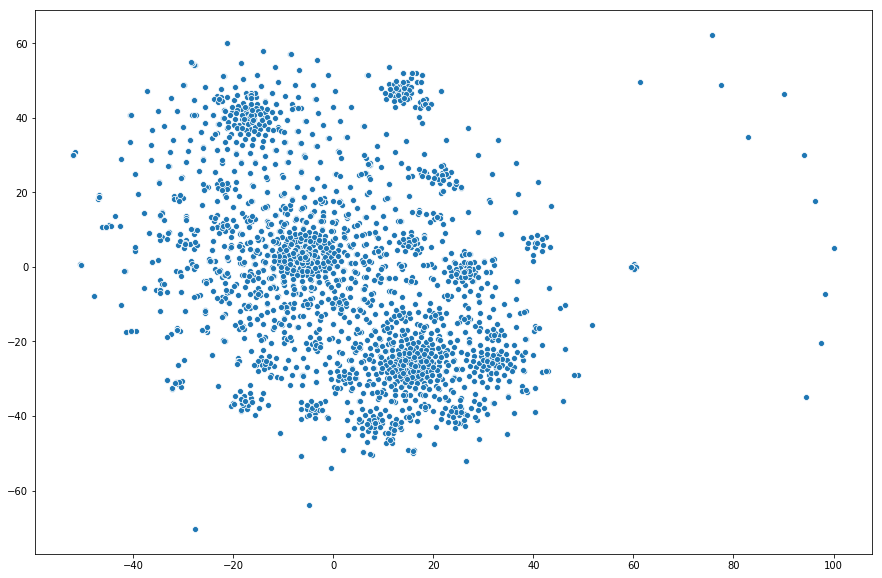

In [259]:
%%time
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

svd_X_tokens_train = svd_on_counters.transform(X_tokens_train)
svd_X_tokens_test = svd_on_counters.transform(X_tokens_test)

X = scipy.sparse.vstack((svd_X_tokens_train, svd_X_tokens_test)).toarray()

tsne = TSNE(n_components=2, random_state=None)
X_embedded = tsne.fit_transform(X)

plt.figure(figsize=(15, 10))
sns.scatterplot(
    X_embedded[:, 0],
    X_embedded[:, 1],
);

##  Looks like we have like 10-20 events, let's run KMEANS

In [262]:
import sklearn as sk
import numpy as np
import matplotlib as plt
from sklearn.preprocessing import normalize, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import silhouette_score
RAND_STATE=50  # for reproducibility and consistency
folds=3
k_fold = KFold(n_splits=folds, shuffle=True, random_state=RAND_STATE) 
hyperparams = {
    "n_clusters": list(range(10,25)),
}

k_means = KMeans() 
ensemble = GridSearchCV(
    estimator=k_means,
    param_grid=hyperparams,
    cv=k_fold,
    verbose=1
)
ensemble.fit(X)
print(ensemble.best_params_)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   38.3s finished


GridSearchCV(cv=KFold(n_splits=3, random_state=50, shuffle=True),
       error_score='raise-deprecating',
       estimator=KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_clusters': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

{'n_clusters': 24}


In [263]:
# Generate labels for data with model with raw data, compute score
labels = ensemble.predict(X)
score = silhouette_score(X, labels)
print(score)

0.045799944763544154


## Lets color our previous tSNE representation, to see how ours predictions fit the picture

<Figure size 1080x720 with 0 Axes>

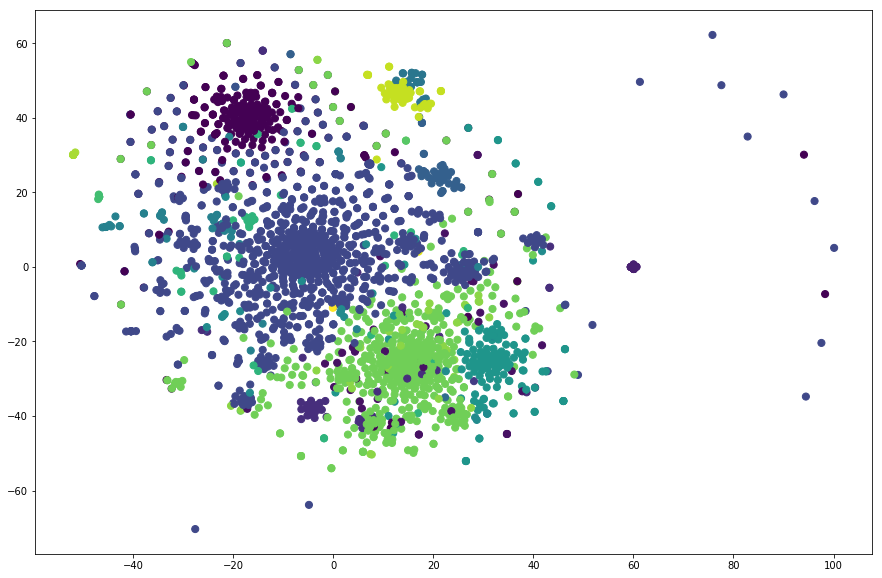

In [293]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm

plt.figure(figsize=(15, 10))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labels, s=50, cmap='viridis')

## Lets take a look to tweets from one cluster(event)

In [284]:
# label_id = 3 ## something about "steve job"
label_id = 9  ## something about "android ice cream sandwich announc"

tweets = pd.concat([X_tweets_train, X_tweets_test])

df = pd.DataFrame(dict(tweet_words=tweets,label=labels))
df[df['label'] == label_id]

,tweet_words,label
987,rt p1j android ice cream sandwich googl nexu n...,9
1037,sweet ice cream sandwich rt pocketlint googl a...,9
1049,love googl releas android os ice cream sandwich,9
1110,new galaxi nexu os improv built ice cream sand...,9
1127,introduc new android tablet call ice cream san...,9
1163,samsung galaxi nexu android ice cream sandwich...,9
1187,android ice cream sandwich galaxi nexu everyth...,9
1197,android ice cream sandwich announc roundup,9
1198,android ice cream sandwich announc roundup,9
1199,android ice cream sandwich announc roundup,9


## Let's predict label for a new tweet

In [295]:
new_tweet = "My mam's friend son was very happy when his phone got a new version of Android - ice cream sandwich!" #should be 9
# new_tweet = "Usually Steve jobs was a god man, but once he forgot to send to Marat free Iphone:(" #should be 3
clean_message = process_message(new_tweet)
count_vectorized_message = count_vectorizer.transform([clean_message])
svd_representation = svd_on_counters.transform(count_vectorized_message)
knn_prediction = ensemble.predict(svd_representation)
print("label for new tweet:", knn_prediction[0])

label for new tweet: 9


## Combine all features

In [ ]:
X_train = scipy.sparse.hstack((X_tokens_train, manual_features_train))
X_test = scipy.sparse.hstack((X_tokens_test, manual_features_test))

## All features + company_name added to features

In [ ]:
# train["Topic"] = train["Topic"].astype(pd.api.types.CategoricalDtype(categories = ["apple", "microsoft","google","twitter"]))
# test["Topic"] = test["Topic"].astype(pd.api.types.CategoricalDtype(categories = ["apple", "microsoft","google","twitter"]))
# test["Topic"] = test["Topic"].astype('category') #py2
hotTrain = pd.get_dummies(train['Topic'], prefix='company')#dummy_na=True
hotTest = pd.get_dummies(test['Topic'], prefix='company')
company_cols = ['company_apple', 'company_twitter', 'company_microsoft', 'company_google']
X_train_with_comp = scipy.sparse.hstack((X_train, hotTrain[company_cols].values))
X_test_with_comp = scipy.sparse.hstack((X_test, hotTest[company_cols].values))
X_train_with_comp

# Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf_cls_sentiment = RandomForestClassifier(n_estimators=100)

In [ ]:
%%time
rf_cls_sentiment.fit(X_sent_score_train, train['Sentiment'])

In [ ]:
rf_cls_sentiment.score(X_sent_score_train, train['Sentiment'])
rf_cls_sentiment.score(X_sent_score_test, test['Sentiment'])

In [ ]:
f1_score(train['Sentiment'], rf_cls_sentiment.predict(X_sent_score_train), average='weighted')
f1_score(test['Sentiment'], rf_cls_sentiment.predict(X_sent_score_test), average='weighted')

# Naïve Bayes Model

In [ ]:
from sklearn.naive_bayes import MultinomialNB

## Sentiment

In [ ]:
%%time
nb_cls_sentiment = MultinomialNB()
nb_cls_sentiment.fit(X_train, train['Sentiment'])

In [ ]:
nb_cls_sentiment.score(X_train, train['Sentiment']) # deleted  single numbers, but not like ios5 or iphone10, because its model
nb_cls_sentiment.score(X_test, test['Sentiment'])

In [ ]:
f1_score(train['Sentiment'], nb_cls_sentiment.predict(X_train), average='weighted')
f1_score(test['Sentiment'], nb_cls_sentiment.predict(X_test), average='weighted')

In [ ]:
def models_api(request_sentiment, classifier):
    processed_request = process_message(request_sentiment)
    print("processed_request:", processed_request)
    vectorized = count_vectorizer.transform([processed_request])
    cls_score = classifier.predict_proba(
        scipy.sparse.hstack(
            (vectorized.toarray(), get_manual_features(request_sentiment))
        )
    )
    return cls_score

### API

In [ ]:
request_sentiment = "@apple @siri is efffing amazing!!))"
models_api(request_sentiment, nb_cls_sentiment)

## Topic(company_name)

In [ ]:
%%time
nb_cls_topic = MultinomialNB()
nb_cls_topic.fit(X_train, train['Topic'])

In [ ]:
nb_cls_topic.score(X_train, train['Topic'])
nb_cls_topic.score(X_test, test['Topic'])

In [ ]:
f1_score(train['Topic'], nb_cls_topic.predict(X_train), average='weighted')
f1_score(test['Topic'], nb_cls_topic.predict(X_test), average='weighted')

### API

In [ ]:
request_sentiment = "@apple @siri is efffing amazing!!))"
models_api(request_sentiment, nb_cls_topic)

## Sentiment on all features+company_name

In [ ]:
%%time
nb_cls_sentiment_ext = MultinomialNB()
nb_cls_sentiment_ext.fit(X_train_with_comp, train['Sentiment'])

In [ ]:
nb_cls_sentiment_ext.score(X_train_with_comp, train['Sentiment'])
nb_cls_sentiment_ext.score(X_test_with_comp, test['Sentiment'])

In [ ]:
f1_score(train['Sentiment'], nb_cls_sentiment_ext.predict(X_train_with_comp), average='weighted')
f1_score(test['Sentiment'], nb_cls_sentiment_ext.predict(X_test_with_comp), average='weighted')

### API

In [ ]:
request_sentiment = ("@apple @siri is efffing amazing!!))", "apple")

processed_request = process_message(request_sentiment[0])
request_topic = request_sentiment[1]
print("processed_request:", processed_request)
vectorized = count_vectorizer.transform([processed_request])
hot_topic = np.array([
    request_topic == 'apple',
    request_topic == 'google',
    request_topic == 'microsoft',
    request_topic == 'twitter']
).astype('int')
cls_score = nb_cls_sentiment_ext.predict_proba(
    scipy.sparse.hstack(
        (vectorized.toarray(), get_manual_features(request_sentiment[0]), hot_topic)
    )
)
print(cls_score)

# Random Forest Classifier again

In [ ]:
X_sent_score_ext_train = np.c_[nb_cls_sentiment_ext.predict_proba(X_train_with_comp), X_sent_score_train]
X_sent_score_ext_test = np.c_[nb_cls_sentiment_ext.predict_proba(X_test_with_comp), X_sent_score_test]

In [ ]:
%%time
rf_cls_sentiment_ext = RandomForestClassifier(n_estimators=100)
rf_cls_sentiment_ext.fit(X_sent_score_ext_train, train['Sentiment'])

In [ ]:
rf_cls_sentiment_ext.score(X_sent_score_ext_train, train['Sentiment'])
rf_cls_sentiment_ext.score(X_sent_score_ext_test, test['Sentiment'])

In [ ]:
f1_score(train['Sentiment'], rf_cls_sentiment_ext.predict(X_sent_score_ext_train), average='weighted')
f1_score(test['Sentiment'], rf_cls_sentiment_ext.predict(X_sent_score_ext_test), average='weighted')

## LSTM

In [60]:
import numpy
# from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout, Conv1D, MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras.utils as ku
# fix random seed for reproducibility
numpy.random.seed(7)

In [61]:
tokenizer = Tokenizer()

def dataset_preparation(corpus):
    #to obtain the tokens and their index in the corpus. 
    tokenizer.fit_on_texts(corpus)
    total_words = len(tokenizer.word_index) + 1
    
    #to convert the corpus into a flat dataset of sentence sequences
    input_sequences = []
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]        
#         for i in range(0, len(token_list)): #if you need to consider all posbl ngramms
#             n_gram_sequence = token_list[:i+1]
#             input_sequences.append(n_gram_sequence)
        input_sequences.append(token_list)            
    #to pad the sequences and make their lengths equal 
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences,   
                          maxlen=max_sequence_len, padding='pre'))
    return input_sequences, max_sequence_len, total_words

In [62]:
all_tweets = np.concatenate((X_tweets_train.values, X_tweets_test.values), axis=0)
print(all_tweets.shape)

processed_tweets, max_tweet_legth, total_words = dataset_preparation(all_tweets)
print(processed_tweets.shape)

X_processed_tweets_train = processed_tweets[ :X_tweets_train.shape[0]]
X_processed_tweets_test = processed_tweets[X_tweets_train.shape[0] : ]

(2509,)
(2509, 19)


In [63]:
#you can see, iphon has code=4
print(X_tweets_train[0])
print(processed_tweets[0])
print(X_tweets_train[1])
print(processed_tweets[1])

appl get swype iphon crack iphon
[   0    0    0    0    0    0    0    0    0    0    0    0    0    1
    6 1706    4  562    4]
appl ad carrier support iphon announc
[  0   0   0   0   0   0   0   0   0   0   0   0   0   1 283 353 146   4
 186]


In [64]:
d = {"positive":1,"negative":-1,"neutral":0}
Y_train = ku.to_categorical(train['Sentiment'].map(d), num_classes=3)
Y_test = ku.to_categorical(test['Sentiment'].map(d), num_classes=3)

In [67]:
import gensim
processed_tweets = processed_tweets.astype('float')
# let X be a list of tokenized texts (i.e. list of lists of tokens)
model = gensim.models.Word2Vec(processed_tweets, size=max_tweet_legth)
# w2v = dict(zip(model.wv.index2word, model.wv.syn0))

TypeError: ufunc 'add' did not contain a loop with signature matching types dtype('<U32') dtype('<U32') dtype('<U32')

In [61]:
import keras.backend as K

def f1_score(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0

    # How many selected items are relevant?
    precision = c1 / c2

    # How many relevant items are selected?
    recall = c1 / c3

    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score

In [63]:
# create the model
embedding_vecor_length = 64
model = Sequential()
model.add(Embedding(total_words, embedding_vecor_length, input_length=max_tweet_legth))
model.add(LSTM(50))
# model.add(Dropout(0.1))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', f1_score])
print(model.summary())
model.fit(X_processed_tweets_train, Y_train, validation_data=(X_processed_tweets_test, Y_test), epochs=10, batch_size=64)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 19, 64)            260864    
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)                23000     
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 153       
Total params: 284,017
Trainable params: 284,017
Non-trainable params: 0
_________________________________________________________________
None
Train on 2272 samples, validate on 237 samples
Epoch 1/10
2272/2272 [==============================] - 1s - loss: 0.9498 - acc: 0.6364 - f1_score: nan - val_loss: 0.8482 - val_acc: 0.6582 - val_f1_score: 0.6493
Epoch 2/10
2272/2272 [==============================] - 0s - loss: 0.8348 - acc: 0.6488 - f1_score: 0.6629 - val_loss: 0.8048 - val_acc: 0.6667 - val_f1_score: 0.6604
Epoch 3/10
2272/2

In [68]:
# create the model
embedding_vecor_length = 64
model = Sequential()
model.add(Embedding(total_words, embedding_vecor_length, input_length=max_tweet_legth))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_processed_tweets_train, Y_train, validation_data=(X_processed_tweets_test, Y_test), epochs=7, batch_size=64)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 19, 64)            260864    
_________________________________________________________________
dropout_5 (Dropout)          (None, 19, 64)            0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 100)               66000     
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 303       
Total params: 327,167
Trainable params: 327,167
Non-trainable params: 0
_________________________________________________________________
None
Train on 2272 samples, validate on 237 samples
Epoch 1/7
2272/2272 [==============================] - 1s - loss: 0.9401 - acc: 0.63

In [65]:
# create the model
embedding_vecor_length = 10
model = Sequential()
model.add(Embedding(total_words, embedding_vecor_length, input_length=max_tweet_legth))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_processed_tweets_train, Y_train, validation_data=(X_processed_tweets_test, Y_test), epochs=10, batch_size=64)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 19, 10)            40760     
_________________________________________________________________
lstm_6 (LSTM)                (None, 100)               44400     
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 303       
Total params: 85,463
Trainable params: 85,463
Non-trainable params: 0
_________________________________________________________________
None
Train on 2272 samples, validate on 237 samples
Epoch 1/10
2272/2272 [==============================] - 1s - loss: 0.9452 - acc: 0.6422 - val_loss: 0.8648 - val_acc: 0.6582
Epoch 2/10
2272/2272 [==============================] - 0s - loss: 0.8807 - acc: 0.6492 - val_loss: 0.8594 - val_acc: 0.6582
Epoch 3/10
2272/2272 [==============================] - 0s - loss: 0.8600 - acc: 0.6492 - val_loss: 

In [66]:
# create the model
embedding_vecor_length = 10
model = Sequential()
model.add(Embedding(total_words, embedding_vecor_length, input_length=max_tweet_legth))
model.add(Conv1D(filters=12, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_processed_tweets_train, Y_train, validation_data=(X_processed_tweets_test, Y_test), epochs=10, batch_size=64)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 19, 10)            40760     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 19, 12)            372       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 9, 12)             0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 100)               45200     
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 303       
Total params: 86,635
Trainable params: 86,635
Non-trainable params: 0
_________________________________________________________________
None
Train on 2272 samples, validate on 237 samples
Epoch 1/10
2272/2272 [==============================] - 1s - loss: 0.9510 - acc: 0.635

# Find more then 3 classes

In [86]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [87]:
from sklearn.manifold import TSNE

In [88]:
X = scipy.sparse.vstack((X_train_with_comp, X_test_with_comp)).toarray()

In [89]:
y = np.r_[train['Sentiment'].values, test['Sentiment'].values]

In [90]:
%%time
tsne = TSNE(n_components=2, random_state=None)
X_embedded = tsne.fit_transform(X)

CPU times: user 1min 53s, sys: 6.46 s, total: 1min 59s
Wall time: 2min 1s


In [91]:
X_embedded

array([[  5.325433 ,  23.571213 ],
       [  2.8626156,  24.460033 ],
       [ 10.928059 ,  22.05847  ],
       ...,
       [ 18.483738 , -19.652021 ],
       [ 26.930134 , -26.155321 ],
       [ 22.923584 , -23.802393 ]], dtype=float32)

In [92]:
y

array(['positive', 'positive', 'positive', ..., 'neutral', 'neutral',
       'neutral'], dtype=object)

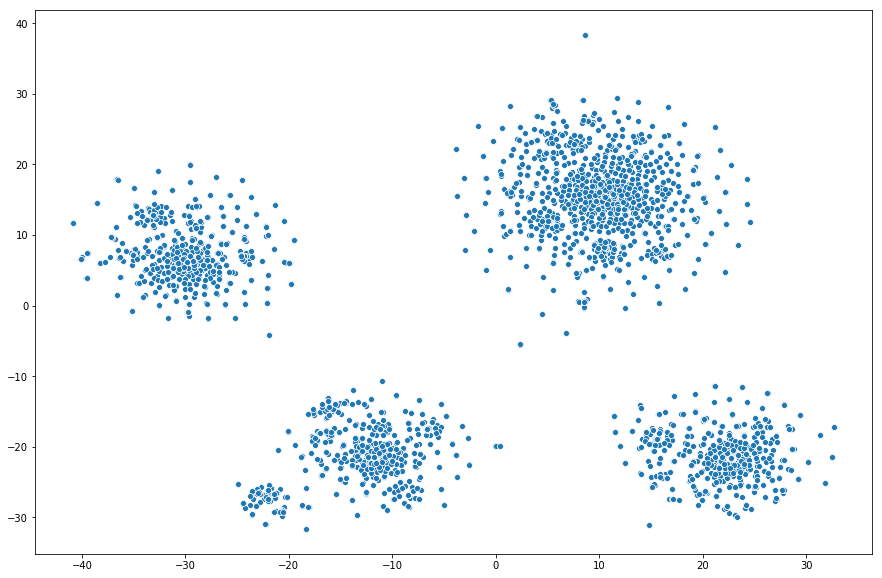

In [101]:
c_map = y[::]
c_map[c_map == 'positive'] = 'blue'
c_map[c_map == 'neutral'] = 'green'
c_map[c_map == 'negative'] = 'red'

plt.figure(figsize=(15, 10))
sns.scatterplot(
    X_embedded[:, 0],
    X_embedded[:, 1],
#     alpha=0.6,
#     c=c_map,
);